In [1]:
!pip install transformers
!pip install sentencepiece
import sentencepiece
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd
import torchtext.data as ttd

## Loading Dataset

We will use The 20 Newsgroups dataset 
Dataset [homepage](http://qwone.com/~jason/20Newsgroups/): 

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset-- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html. We'll use them below to retrieve the dataset.

Also look at results fron non- neural net models here : https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  2 07:46:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [5]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [6]:
print(train.target[0])

7


In [7]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


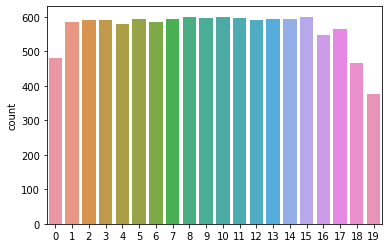

In [8]:
import seaborn as sns

# Plot the number of tokens of each length.
sns.countplot(train.target);

#XLNet with 128 features and truncating at end

In [10]:
from transformers import XLNetTokenizer

# Load the BERT tokenizer.
print('Loading XLNet tokenizer...')
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

Loading XLNet tokenizer...


In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', train.data[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Token IDs: tensor([    5,     5,     5,    17,   150,    30,  7083,   108,  1216,    78,
          105,   121, 22531,   110,    31,    52,   398,    17,   150,   685,
           18,    86,   191,     9,    36,    30,    24,   159,    13,  9381,
         1721,   398,    19,   719,    22,    39,    40,    18,   471,  1639,
           23,   167,   319,  2415,    23,     9,    36,    30,   271,    24,
         5989,  1554,     9,    18,  3965,    55,   343,   316,     9,    25,
          864,    19,    18,   605

In [12]:
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', test.data[0])
print('Token IDs:', test_input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
Token IDs: tensor([    5,     5,     5,     5,    17,   150,   569,    24,   293,  6833,
           31,    71,    20,    18,  2626,    20,    18, 10227,    13,  4406,
           17,  4769,   667,  1948,    23,     9,    17,   150,    47,  1133,
           20,    18,    17,   529,    17,  1022,    17,   368,  1022,    17,
           23,  1022,    17,    23,    23,  5730,     9,   121,   886,   759,
          110,    18,  3589,    41,   420,    34,  1091,    49,   922,     9,
           17,   150,   569,    77,  8595,    22, 

In [13]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


#Training just the Fully Connected Classifier layer by freezing the XLNet model weights


In [15]:
from transformers import  XLNetModel

bert_model = XLNetModel.from_pretrained('xlnet-base-cased')

In [16]:
bert_model

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, b

In [20]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    #self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(768 , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [21]:
n_outputs = 20
dropout_rate = 0.5

In [22]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [23]:
print(model)

linear(
  (bert_model): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [24]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.mask_emb torch.Size([1, 1, 768])
bert_model.word_embedding.weight torch.Size([32000, 768])
bert_model.layer.0.rel_attn.q torch.Size([768, 12, 64])
bert_model.layer.0.rel_attn.k torch.Size([768, 12, 64])
bert_model.layer.0.rel_attn.v torch.Size([768, 12, 64])
bert_model.layer.0.rel_attn.o torch.Size([768, 12, 64])
bert_model.layer.0.rel_attn.r torch.Size([768, 12, 64])
bert_model.layer.0.rel_attn.r_r_bias torch.Size([12, 64])
bert_model.layer.0.rel_attn.r_s_bias torch.Size([12, 64])
bert_model.layer.0.rel_attn.r_w_bias torch.Size([12, 64])
bert_model.layer.0.rel_attn.seg_embed torch.Size([2, 12, 64])
bert_model.layer.0.rel_attn.layer_norm.weight torch.Size([768])
bert_model.layer.0.rel_attn.layer_norm.bias torch.Size([768])
bert_model.layer.0.ff.layer_norm.weight torch.Size([768])
bert_model.layer.0.ff.layer_norm.bias torch.Size([768])
bert_model.layer.0.ff.layer_1.weight torch.Size([3072, 768])
bert_model.layer.0.ff.layer_1.bias torch.Size([3072])
bert_model.layer.0.ff.layer

In [25]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 3.5173    Valid Loss: 2.8577, Duration: 0:00:42.563540
Epoch 2/10, Train Loss: 3.3863    Valid Loss: 2.7111, Duration: 0:00:43.053556
Epoch 3/10, Train Loss: 3.3450    Valid Loss: 2.7488, Duration: 0:00:43.140066
Epoch 4/10, Train Loss: 3.3610    Valid Loss: 2.7833, Duration: 0:00:43.226663
Epoch 5/10, Train Loss: 3.3945    Valid Loss: 2.8700, Duration: 0:00:43.207317
Epoch 6/10, Train Loss: 3.3625    Valid Loss: 2.8428, Duration: 0:00:43.233899
Epoch 7/10, Train Loss: 3.3979    Valid Loss: 2.7324, Duration: 0:00:43.238347
Epoch 8/10, Train Loss: 3.4011    Valid Loss: 2.6344, Duration: 0:00:43.202970
Epoch 9/10, Train Loss: 3.4075    Valid Loss: 2.7247, Duration: 0:00:43.184335
Epoch 10/10, Train Loss: 3.4261    Valid Loss: 2.6287, Duration: 0:00:43.196169


In [26]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [27]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.3389,	 Valid acc: 0.2686,	 Test acc: 0.2593


In [28]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [29]:
y_test, predictions=get_predictions(test_dataloader, model)

In [30]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 19,   3,  10,   3,  42,  13,  10,  20,  10,   0,   9,  22,   2,
         29,   2,  54,  34,  15,  13,   9],
       [  0,  26,  64,  29,  58,  60,  42,  13,   4,   0,   0,  21,  30,
         11,   5,   6,   9,   6,   3,   2],
       [  1,  14,  84,  50,  63,  66,  21,  21,   8,   2,   0,  19,  15,
          5,   2,   6,   9,   2,   5,   1],
       [  0,   5,  52,  97,  73,  22,  45,  14,   7,   1,   2,  15,  32,
          2,   1,   2,  11,   0,   4,   7],
       [  0,   5,  51,  73,  98,  17,  48,  20,   0,   1,   1,  13,  24,
         12,   3,   0,  13,   0,   5,   1],
       [  1,  18,  62,  26,  48, 133,  33,   6,   5,   0,   4,  22,  14,
          2,   1,   3,   7,   3,   6,   1],
       [  0,   4,  19,  25,  30,   9, 253,  15,   3,   1,   5,   3,  11,
          3,   0,   1,   5,   0,   2,   1],
       [  2,   4,  27,  16,  42,   9,  43, 121,  39,   3,   8,   5,  23,
         13,   0,   2,  31,   3,   4,   1],
       [  1,   5,  27,  20,  63,  12,  42,  48,  81,   5,   3,  

In [31]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

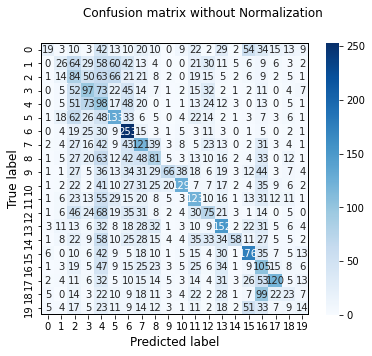

In [32]:
plot_confusion_matrix(y_test,predictions)

#Finetuning the pre-trained XLNet Model




In [33]:
from transformers import XLNetForSequenceClassification, AdamW, XLNetConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", # Use the 12-layer Robera model, with an uncased vocab.
    num_labels = 20, # The number of output labels   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device


device(type='cuda', index=0)

In [35]:
# Tell pytorch to run this model on the GPU.
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [36]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 210 different named parameters.

==== Embedding Layer ====

transformer.mask_emb                                     (1, 1, 768)
transformer.word_embedding.weight                       (32000, 768)
transformer.layer.0.rel_attn.q                          (768, 12, 64)
transformer.layer.0.rel_attn.k                          (768, 12, 64)
transformer.layer.0.rel_attn.v                          (768, 12, 64)

==== First Transformer ====

transformer.layer.0.rel_attn.o                          (768, 12, 64)
transformer.layer.0.rel_attn.r                          (768, 12, 64)
transformer.layer.0.rel_attn.r_r_bias                       (12, 64)
transformer.layer.0.rel_attn.r_s_bias                       (12, 64)
transformer.layer.0.rel_attn.r_w_bias                       (12, 64)
transformer.layer.0.rel_attn.seg_embed                   (2, 12, 64)
transformer.layer.0.rel_attn.layer_norm.weight                (768,)
transformer.layer.0.rel_attn.layer_norm.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

## 4.3. Training Loop

Define a helper function for calculating accuracy.

Helper function for formatting elapsed times as `hh:mm:ss`


We're ready to kick off the training!

In [37]:
# STEP 6: INSTANTIATE OPTIMIZER CLASS
epochs = 2
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() 
          if not any(nd in n for nd in no_decay)], 
         'weight_decay': 0.5},

        {'params': [p for n, p in model.named_parameters() 
        if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0}
        ]

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 5e-5, 
                  eps = 1e-8 
                )

no_decay = ['bias', 'LayerNorm.weight']



from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [38]:
import random
from datetime import datetime

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

epochs = 2

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:  
    b_input_ids = batch[0]
    b_input_mask = batch[1]
    b_labels = batch[2]
    # forward pass

    outputs = model(b_input_ids.to(device), 
                        token_type_ids=None, 
                        attention_mask=b_input_mask.to(device), 
                        labels=b_labels.to(device))


    # set gradients to zero 
    optimizer.zero_grad()
    # backward pass
    outputs.loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    train_loss.append(outputs.loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
      
      valid_loss.append(outputs.loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/2, Train Loss: 1.4028    Valid Loss: 1.1523, Duration: 0:02:25.167743
Epoch 2/2, Train Loss: 0.7679    Valid Loss: 1.0338, Duration: 0:02:25.047346


In [39]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)

      _,indices = torch.max(outputs.logits,dim=1)
      correct+= (b_labels==indices).sum().item()
      total += b_labels.shape[0]
    
    acc= correct/total

    return acc

In [40]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader, model)

In [41]:
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.8517,	 Valid acc: 0.6935,	 Test acc: 0.6771


In [42]:
# Write a function to get predictions
def get_predictions(data_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in data_iter:
      
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
      
      _,indices = torch.max(outputs.logits,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,b_labels.cpu().numpy())) 
      
  return y_test, predictions

In [43]:
y_valid, predictions=get_predictions(validation_dataloader, model)

In [44]:
predictions.max()

19.0

In [45]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid,predictions)
cm

array([[32,  0,  0,  0,  0,  0,  0,  4,  0,  0,  1,  1,  0,  0,  1,  7,
         0,  0,  1,  1],
       [ 0, 36,  7,  1,  0,  4,  0,  0,  0,  1,  0,  0,  2,  0,  3,  0,
         0,  1,  0,  0],
       [ 0,  1, 33,  6,  0,  4,  1,  2,  1,  1,  0,  2,  2,  1,  0,  1,
         0,  0,  0,  0],
       [ 0,  1,  7, 52,  3,  0,  2,  4,  0,  0,  0,  0,  4,  0,  0,  1,
         0,  0,  0,  0],
       [ 1,  3,  2,  7, 31,  0,  3,  4,  0,  0,  0,  0,  6,  0,  0,  1,
         0,  0,  0,  0],
       [ 0,  3,  6,  0,  0, 52,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  2,  0,  1],
       [ 0,  1,  1,  1,  0,  0, 49,  5,  1,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 42,  9,  0,  0,  0,  1,  0,  0,  0,
         4,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  7, 43,  1,  0,  1,  2,  1,  2,  0,
         3,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  4,  1, 44,  6,  0,  1,  0,  1,  0,
         0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

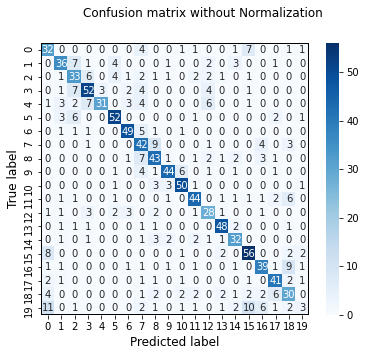

In [47]:
plot_confusion_matrix(y_valid,predictions)